
### Analysis of LFADS input timing 

This is an examination of when LFADS controller outputs occur. As shown below, the inputs are sparse in time, and so the goal is to determine when the sharp peaks occur

TODO: measures of sparsity of the inputs

In [1]:
from scipy.io import loadmat
import sys
import h5py
sys.path.insert(0, '/home/pmalonis/lfads_analysis/src')
import utils
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
%matplotlib inline

trial_type = 'all'

sparse_filename = "/home/pmalonis/226_figs/rockstar_8QTVEk_%s.h5"%trial_type
data_filename = "/home/pmalonis/lfads_analysis/data/intermediate/rockstar.p"
inputInfo_filename = "/home/pmalonis/lfads_analysis/data/model_output/rockstar_inputInfo.mat"

input_info = loadmat(inputInfo_filename)
used_inds = utils.get_indices(input_info, trial_type)

df = pd.read_pickle(data_filename)
ntrials = 10

with h5py.File(sparse_filename) as h5file:
    trial_len_ms = input_info['seq_timeVector'][-1][-1]
    dt = np.round(trial_len_ms/h5file['controller_outputs'].shape[1])/1000 
    trial_len = trial_len_ms/1000
    trial_len = np.floor(trial_len/dt)*dt
    lfads_t = np.arange(0, trial_len, dt)
    plt.figure(figsize=(15,20))
    for i, trial_idx in enumerate(used_inds[:ntrials]):
        plt.subplot(ntrials, 2, i + 1)
        n_inputs = h5file['controller_outputs'].shape[2]
        targets = df.loc[trial_idx].kinematic.loc[:trial_len].query('hit_target').index.values
        plt.vlines(targets, -.8,.8)
        legend = []
        for input_idx in range(n_inputs):
            plt.plot(lfads_t, h5file['controller_outputs'][i,:,input_idx])
            legend.append('input %d'%input_idx)

        plt.legend(legend)

NameError: name 'j' is not defined

<Figure size 1080x1440 with 0 Axes>

As is evident from the plots, peaks in the controller outputs tend to occur immediately after target appearances. The following is a distribution of latencies between taret appearances and the next peak, for peaks which occur within 500ms of a target appearance. I'll use a range of thresholds for peak appearances.

In [17]:
import sys
sys.path.insert(0, '/home/pmalonis/lfads_analysis/src')
import timing_analysis as ta
import segment_submovements as ss
import seaborn as sns
from scipy import io
import utils
import importlib
importlib.reload(ta)
importlib.reload(ss)

lfads_filename = "/home/pmalonis/lfads_analysis/data/model_output/rockstar_8QTVEk_%s.h5"%trial_type
data_filename = "/home/pmalonis/lfads_analysis/data/intermediate/rockstar.p"
inputInfo_filename = "/home/pmalonis/lfads_analysis/data/model_output/rockstar_inputInfo.mat"

#limits of window to look for peaks after target appearance
win_start = 0
win_stop = 0.5
# minimum distance between peaks
min_distance = 5

df = pd.read_pickle(data_filename)
input_info = io.loadmat(inputInfo_filename)
with h5py.File(lfads_filename) as h5file:
    co = h5file['controller_outputs'].value
    dt = utils.get_dt(h5file, input_info)
    n_inputs = h5file['controller_outputs'].shape[2]

peak_thresholds = [.1, .2, .3, .4]
peak_dfs = []
for peak_thresh in peak_thresholds:
    targets = ta.get_targets(df)
    peaks = ta.get_peaks(co, dt, peak_thresh, min_distance)
    target_peaks, peak_counts = ta.get_latencies(targets, peaks, win_start, win_stop)
    peak_dfs.append(target_peaks)

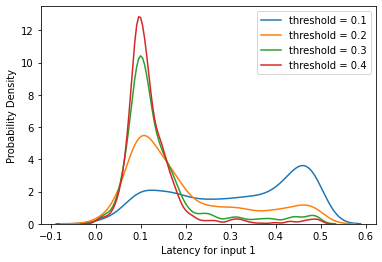

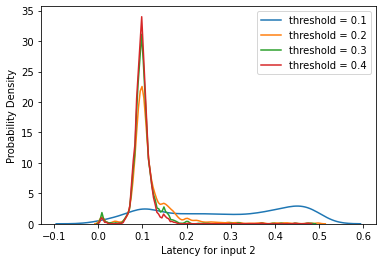

In [40]:
for i in range(n_inputs):
    plt.figure()
    for j, p in enumerate(peak_thresholds):
        label = 'threshold = %0.1f'%p
        sns.distplot(peak_dfs[j]['latency_%d'%i], 
                     hist=False, label=label)

    plt.legend()
    plt.xlabel('Latency for input %d'%(i+1))
    plt.ylabel('Probability Density')


&lt;matplotlib.axes._subplots.AxesSubplot at 0x7fdd7965b9b0&gt;

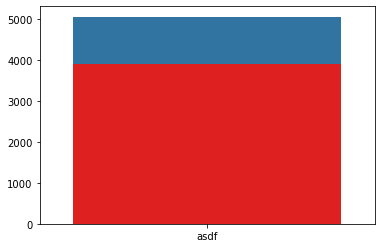

In [64]:
from importlib import reload
reload(ta)
total_targets = targets.shape[0]
inputs = list(range(n_inputs))
targets_with_peak = [ta.get_target_peak_counts(target_peaks, input_idx) for input_idx in inputs]
targets_any = ta.get_target_peak_counts(target_peaks, inputs, all_inputs=False)
targets_all = ta.get_target_peak_counts(target_peaks, inputs, all_inputs=True)

sns.barplot(x=['asdf'], y=total_targets)
sns.barplot(x=['asdf'], y=targets_with_peak[0],color='red')

In [58]:
peak_dfs

[3908, 3714]